<a href="https://colab.research.google.com/github/codingmonster07/vigilant-waffle/blob/main/Random_Forest_Predictive_Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mean Absolute Error (MAE): 0.003425985376054712
Root Mean Squared Error (RMSE): 0.005112624774727448

Predicted Next Day Prices:
   Predicted_Open  Predicted_High  Predicted_Low  Predicted_Close
0          1.0488        1.051425       1.044037         1.046907

Actual Next Day Prices:
      Actual_Open Actual_High Actual_Low Actual_Close
13857     1.04977     1.05055    1.04497      1.04608


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


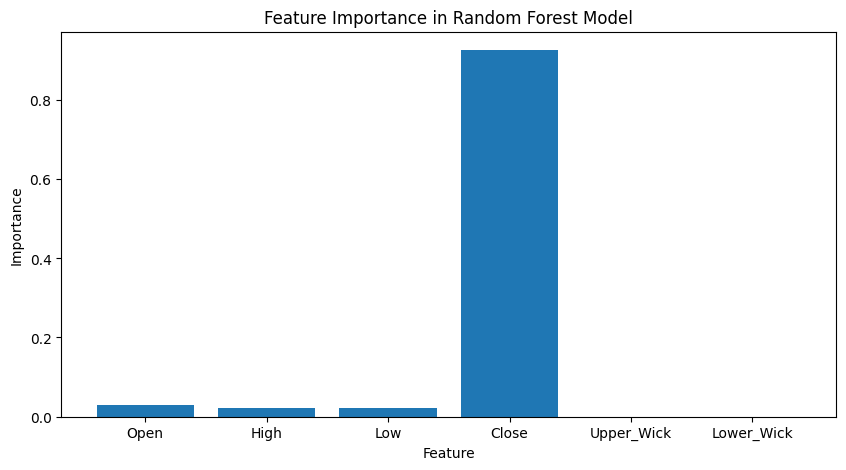

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/eurusd_d.csv")

# Convert Date column to datetime and sort
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date")

# Compute wick lengths
df["Upper_Wick"] = df["High"] - df[["Open", "Close"]].max(axis=1)
df["Lower_Wick"] = df[["Open", "Close"]].min(axis=1) - df["Low"]

# Create target variables (next day's prices)
df["Next_Open"] = df["Open"].shift(-1)
df["Next_High"] = df["High"].shift(-1)
df["Next_Low"] = df["Low"].shift(-1)
df["Next_Close"] = df["Close"].shift(-1)

# Drop last row since it has NaN values after shifting
df = df.dropna()

# Define feature columns and target variables
features = ["Open", "High", "Low", "Close", "Upper_Wick", "Lower_Wick"]
targets = ["Next_Open", "Next_High", "Next_Low", "Next_Close"]

# Split data into training (80%) and testing (20%)
train_data, test_data = train_test_split(df, test_size=0.3, shuffle=False)

# Separate features and targets
X_train, y_train = train_data[features], train_data[targets]
X_test, y_test = test_data[features], test_data[targets]

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Predict the next day's prices using the latest available data
latest_data = df[features].iloc[-1:].values
predicted_next_day = model.predict(latest_data)

# Format and display prediction
predicted_df = pd.DataFrame(predicted_next_day, columns=["Predicted_Open", "Predicted_High", "Predicted_Low", "Predicted_Close"])
print("\nPredicted Next Day Prices:")
print(predicted_df)

# Retrieve the actual next day's values for comparison
actual_next_day = df.iloc[-1][["Next_Open", "Next_High", "Next_Low", "Next_Close"]].to_frame().T
actual_next_day.columns = ["Actual_Open", "Actual_High", "Actual_Low", "Actual_Close"]
print("\nActual Next Day Prices:")
print(actual_next_day)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.bar(features, model.feature_importances_)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest Model")
plt.show()


In [5]:
# Import required libraries for LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Select features and targets
features = ["Open", "High", "Low", "Close", "Upper_Wick", "Lower_Wick"]
targets = ["Next_Open", "Next_High", "Next_Low", "Next_Close"]

# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[features + targets])

# Convert dataset into supervised learning format
def create_sequences(data, target, sequence_length):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, :len(features)])  # Past price movements
        Y.append(data[i+sequence_length, len(features):])  # Next day's prices
    return np.array(X), np.array(Y)

# Define sequence length (e.g., past 10 days of data for prediction)
sequence_length = 10

# Create LSTM-compatible datasets
X, Y = create_sequences(df_scaled, targets, sequence_length)

# Split into train (80%) and test (20%) sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(4)  # Output layer for Next_Open, Next_High, Next_Low, Next_Close
])

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Predict on the test set
Y_pred = model.predict(X_test)

# Reverse the scaling to get actual price values
Y_test_actual = scaler.inverse_transform(np.hstack((X_test[:, -1, :], Y_test)))[:, len(features):]
Y_pred_actual = scaler.inverse_transform(np.hstack((X_test[:, -1, :], Y_pred)))[:, len(features):]

# Compute evaluation metrics
mae_lstm = mean_absolute_error(Y_test_actual, Y_pred_actual)
rmse_lstm = np.sqrt(mean_squared_error(Y_test_actual, Y_pred_actual))

# Display LSTM model performance
lstm_performance = pd.DataFrame({
    "LSTM MAE": [mae_lstm],
    "LSTM RMSE": [rmse_lstm]
})

# tools.display_dataframe_to_user(name="LSTM Model Performance", dataframe=lstm_performance)
display(lstm_performance)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


347/347 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0360 - val_loss: 2.9500e-04
Epoch 2/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0020 - val_loss: 8.0895e-04
Epoch 3/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0014 - val_loss: 2.7222e-04
Epoch 4/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0010 - val_loss: 3.6374e-04
Epoch 5/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 8.5784e-04 - val_loss: 2.2431e-04
Epoch 6/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 7.1399e-04 - val_loss: 4.1834e-04
Epoch 7/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 6.2370e-04 - val_loss: 5.9321e-04
Epoch 8/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 5.6290e-04 - val_loss: 1.6808e-04
Epoch 9/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 5.1393e-04 - val_loss: 5.6946e-04
Epoch 10/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 5.1496e-04 - val_loss: 2.3846e-04
Epoch 11/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 4.5854e-04 -

,LSTM MAE,LSTM RMSE
0,0.026979,0.02967
